# DNN model for labeling the architectural styles of buildings

## Import libraries

In [2]:
# IO
import os
import pathlib
from pathlib import Path
from glob import glob

# Utilities
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Import PyTorch
import torch
from torch import nn

# Import torch utilities
from torch.utils.data import DataLoader, TensorDataset

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.io import read_image

# Visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.2
torchvision version: 0.17.2


## GPU availability

In [2]:
torch.cuda.is_available()

False

Line required for the code to be device-agnostic

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

## Import data

Define folders

In [3]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
BROKENDATA_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_brokenData","")

In [4]:
subfolder_list = glob(os.path.join(DATASET_FOLDER,"*","*",""), recursive = True)
styles = [os.path.basename(os.path.normpath(x)) for x in subfolder_list]

Less styles (easier):

In [5]:
folder_list = glob(os.path.join(DATASET_FOLDER,"*",""), recursive = True)
subfolder_list = glob(os.path.join(DATASET_FOLDER,"*","*",""), recursive = True)
styles = [os.path.basename(os.path.normpath(x)) for x in folder_list]

Architectural styles (target) stored in list below

In [6]:
styles

['Early_Christian_Medieval',
 'Modernism',
 '21st_Century',
 'Revivalism',
 'Classical',
 'Renaissance_and_Colonialism',
 'Neoclassicism',
 'Eclecticism',
 'Baroque']

In [8]:
files = []
for style in styles:
    file_jpg = glob(DATASET_FOLDER+f'{style}/**/*.jpg', recursive=True)
    for i, f in enumerate(file_jpg):
        files.append(f)
files

['/Users/exterior/Documents/IML/Project/Part2/_data/Early_Christian_Medieval/Gothic architecture/31310.jpg',
 '/Users/exterior/Documents/IML/Project/Part2/_data/Early_Christian_Medieval/Gothic architecture/31304.jpg',
 '/Users/exterior/Documents/IML/Project/Part2/_data/Early_Christian_Medieval/Gothic architecture/31112.jpg',
 '/Users/exterior/Documents/IML/Project/Part2/_data/Early_Christian_Medieval/Gothic architecture/31106.jpg',
 '/Users/exterior/Documents/IML/Project/Part2/_data/Early_Christian_Medieval/Gothic architecture/3168.jpg',
 '/Users/exterior/Documents/IML/Project/Part2/_data/Early_Christian_Medieval/Gothic architecture/3154.jpg',
 '/Users/exterior/Documents/IML/Project/Part2/_data/Early_Christian_Medieval/Gothic architecture/3140.jpg',
 '/Users/exterior/Documents/IML/Project/Part2/_data/Early_Christian_Medieval/Gothic architecture/3197.jpg',
 '/Users/exterior/Documents/IML/Project/Part2/_data/Early_Christian_Medieval/Gothic architecture/3183.jpg',
 '/Users/exterior/Docume

Set batch size and minimum dimension

In [ ]:
BATCH_SIZE = 32
DIM = 256

Check for broken images and move them to a specific folder

In [4]:
for i in range(len(subfolder_list)):
    for filename in os.listdir(subfolder_list[i]):
        image_path = str(subfolder_list[i]+filename)
        image = cv2.imread(image_path)
        height, width, channels = image.shape
        # If pic is broken
        if image is None:
            os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)
        # If pic is too small, threshold 128x128
        if min(height,width)<DIM:
            os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)

NameError: name 'subfolder_list' is not defined

Prepare the data

In [2]:
X = []
Xbw = []
targets = []

dim = (DIM,DIM)

for style in styles:
    file_jpg = glob(DATASET_FOLDER+f'{style}/**/*.jpg', recursive=True)

    for i, f in enumerate(file_jpg):
        img = cv2.imread(f)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA) # Best for shrinking
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = img.transpose(2,0,1) # Channel first
        img = img.astype('float32')
        img /= 255 
        img = torch.from_numpy(img)
        gray_image = np.array(gray_image)
        gray_image = gray_image.astype('float32')
        gray_image /= 255 
        gray_image = torch.from_numpy(gray_image)
        X.append(img)
        Xbw.append(gray_image)
        targets.append(style)

NameError: name 'DIM' is not defined

Convert list of tensors into a single tensor with extra dimension

In [41]:
del(X1)
del(Xbw1)

In [42]:
X = torch.stack(X, dim=0)
Xbw = torch.stack(Xbw, dim=0)
Xbw = torch.unsqueeze(Xbw, 1)

In [1]:
Xbw.shape
X.shape

NameError: name 'Xbw' is not defined

Save dataset for future sessions

In [12]:
torch.save(X, os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorX.pt'))
torch.save(Xbw, os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorXbw.pt'))
torch.save(targets, os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorTarget.pt'))

Run code below to load previously saved data

In [7]:
X =  torch.load(os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorX.pt'))
Xbw =  torch.load(os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorXbw.pt'))
targets = torch.load(os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorTarget.pt'))

Encode target variable to numeric

In [44]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(targets)

In [45]:
y = torch.as_tensor(y)
y

tensor([0, 0, 0,  ..., 8, 8, 8])

Check if shape is in NCHW format

In [16]:
X.shape

torch.Size([11532, 3, 128, 128])

In [46]:
# Setup the batch size hyperparameter
X_train, X_test, y_train, y_test = train_test_split(Xbw, y, train_size=0.8, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=42, stratify=y_train)

In [47]:
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
val_loader = DataLoader(val_data, batch_size=len(val_data.tensors[0]))

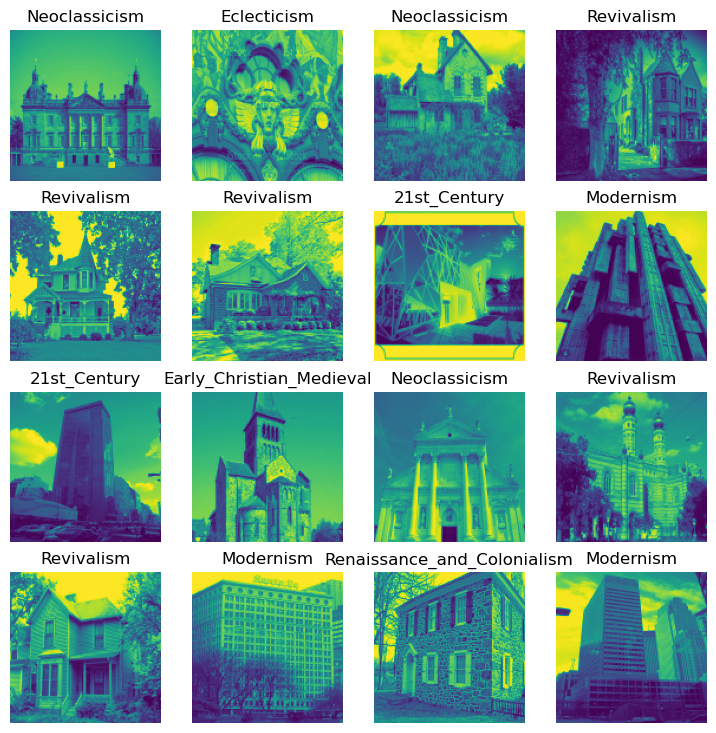

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    img = img.permute(1,2,0)
    plt.imshow(img)
    plt.title(le.inverse_transform([label])[0])
    plt.axis(False);

## Model Building

### Convolutional model

In [38]:
class ArchitectureStyleConvolution(nn.Module):
    def __init__(self, n_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        # input dimension 256x256
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels,
                      out_channels=hidden_units,
                      kernel_size=13, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=13,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,
                         stride=4) # default stride value is same as kernel_size
            # 58x58 here
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=3) # default stride value is same as kernel_size
            # 18x18 here
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*18*18,
                      out_features=150),
            nn.Linear(in_features=150,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

ArchConv = ArchitectureStyleConvolution(n_channels=3, 
    hidden_units=150,
    output_shape=len(styles))
ArchConv

ArchitectureStyleConvolution(
  (block_1): Sequential(
    (0): Conv2d(3, 150, kernel_size=(13, 13), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(150, 150, kernel_size=(13, 13), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(150, 150, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(150, 150, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7350, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=45, bias=True)
  )
)

Send to gpu

In [39]:
ArchConv.to(device)

ArchitectureStyleConvolution(
  (block_1): Sequential(
    (0): Conv2d(3, 150, kernel_size=(13, 13), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(150, 150, kernel_size=(13, 13), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(150, 150, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(150, 150, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7350, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=45, bias=True)
  )
)

torch.Size([11532, 1, 128, 128])

In [28]:
class ArchitectureStyleConvolutionBW(nn.Module):
    def __init__(self, n_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        # input dimension 128x128
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels,
                      out_channels=hidden_units,
                      kernel_size=9, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=9,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=4,
                         stride=4) # default stride value is same as kernel_size
            # 28x28 here
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*3,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*3,
                      out_channels=hidden_units*6,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
            # 10x10 here
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*3,
                      out_channels=hidden_units*6,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*6,
                      out_channels=hidden_units*6,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
            # 9x9 here
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*10*10*6,
                      out_features=150),
            nn.Linear(in_features=150,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        # x = self.block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

ArchConv = ArchitectureStyleConvolutionBW(n_channels=1, 
    hidden_units=6,
    output_shape=len(styles))
ArchConv

ArchitectureStyleConvolutionBW(
  (block_1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 6, kernel_size=(9, 9), stride=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=4, stride=4, padding=0)
  )
  (block_2): Sequential(
    (0): Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(18, 36, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (block_3): Sequential(
    (0): Conv2d(18, 36, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(36, 36, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3600, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=9, bias=True)
  )
)

In [48]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Reshape layer can be handled in the forward method
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)  # Padding 'same' is padding=2 for kernel size 5
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 62 * 62, 120)  # Adjust the input features size according to the final pooled size 62
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(styles))
    
    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)
        return x

model = LeNet5()

### Loss and optimizer

In [49]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

### Build training and testing loop

In [32]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer, accuracy_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### Performance testing

In [33]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time: {total_time:.3f} seconds")
    return total_time

def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

### Evaluation

In [34]:
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

## Training and testing

In [50]:
# Measure time
from timeit import default_timer as timer
train_time_start = timer()

torch.manual_seed(42)

epochs = 50
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end= timer()
total_train_time_model_1 = print_train_time(start=train_time_start, end=train_time_end)

Epoch: 0
---------
Train loss: 2.20405 | Train accuracy: 0.15%
Test loss: 2.20346 | Test accuracy: 0.16%

Epoch: 1
---------
Train loss: 2.20041 | Train accuracy: 0.15%
Test loss: 2.21397 | Test accuracy: 0.16%

Epoch: 2
---------
Train loss: 2.20203 | Train accuracy: 0.16%
Test loss: 2.21414 | Test accuracy: 0.16%

Epoch: 3
---------
Train loss: 2.21321 | Train accuracy: 0.16%
Test loss: 2.21178 | Test accuracy: 0.16%

Epoch: 4
---------
Train loss: 2.21446 | Train accuracy: 0.16%
Test loss: 2.21417 | Test accuracy: 0.16%

Epoch: 5
---------
Train loss: 2.21437 | Train accuracy: 0.16%
Test loss: 2.21417 | Test accuracy: 0.16%

Epoch: 6
---------
Train loss: 2.21445 | Train accuracy: 0.16%
Test loss: 2.21417 | Test accuracy: 0.16%

Epoch: 7
---------


KeyboardInterrupt: 

In [58]:
ArchConv_results = eval_model(model=ArchConv,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn)
ArchConv_results

NameError: name 'ArchConv' is not defined